# Introducton to Simulation with python
### Stephen Elston and Drew Bryant
### Data Science 410

This notebook contains a hands-on introduction to simulation methods. The python language is used to illustrate each major point.

## Introduction

Simulation enables data scientists to study the stochastic behavior of processes with complex probability distributions. Simple processes might be approximated by a known, or 'named' distributon. In these simple cases, it might even be possible to derive analytical results. However, many real-world processes have complex behavior, resulting in complex distributions of output values. In these cases, simulation is a practical approach to understanding these processes. 

As cheap computational power has become ubiquitous, simulation has become a widely used technique in the data scientist's tool box. Simulations compute a large number of cases, or realizations, of the process being studied. The final or posterior distribution of the process being simulated is comprised of these realizations. The computing cost of each realization must be low in any practical simulation. 

Data scientists use simulation for a number of purposes:

- Simulation is used to test models. If data simulated from the model do not resemble the original data, something is likely wrong with the model.
- Simulation is used to understand processes with complex distributions. In these cases, simulation provides a powerful and flexible compuational technique to understand this behavior.  

In this notebook you will create a simulation of a process with a complex distribution. 


## Creating simulations

Creating, testing and debugging simulation software can be tricky. Some of the techniques which can make your life easier are the same as you should use when developing any analytics software, or even software in general. These techniques include:

- Build your simulation as a series of small, easily tested chunks In practice, this means you will build your simulation by creating and testing a set of small functions that comprise the overall model.
- Test each small functional unit individually. These tests should include at least testing some typical cases, as well as boundary or extreme cases. Sensible behavior with extreme or limiting cases is a requirement for a stable simulation. Both tabular and graphical output can be useful for evaluating tests.
- Test your overall simulation each time you add a new funcitonal component. This processes ensures that all the pieces work together. 
- Simulations are inherently stochastic. If you want to create identical numerical results, say for automated testing, set a seed before you begin tests. In this notebook no seed is set so you can experience the stochastic nature of the simulation. 


## The Scenario

The notebook implements a simulation of the profitability of a sandwich shop. Not suprisingly, the sandwich shop earns money every time a customer buys a sandwich. However, the inputs to the sandwich cost money. The daily profit is the amount customers pay for the sandwiches minus the costs of the inputs. 

The cost of bread is a particular input which is difficult to manage. The shop bakes its own bread, and the bread must be used on the day it is made. The customers can select one of three types of bread, white, wheat, and multigrain. The customers are unusually picky. If the shop does not have sufficient bread of the customer's choice on hand, the customer will leave the shop without buying a sandwich. However, any extra bread left at the end of the day is discarded and the cost reduces the profitability of the shop. 

To keep the simulation simple, several assumptions are made:

- The probability that each customer chooses a particular type of bread is fixed and known. There probabilities are 50% for white bread, 25% for wheat and 25% for multigrain. 
- If a customer's choice of bread is not available the customer leaves the shop without buying a sandwich.
- The only perishable input which must be discarded at the end of each day is the bread. 
- Customers do not stop coming to the sandwich shop as a result of not finding their bread choice. 

In reality these are questionable assumptions, and the situation is more complex. However, the simulation techniques we are about to use, can still be applied. 

## Realizations of Distribution

The ability to compute large numbers of realizations from probability distributions is fundamental to simulation. Two questions natuarally arise. 

- Which distribution to choose? The answer to this question is typically determined through a combination of domain knowledge and significant data exploration. Usually, several choices are tested and  compaired.
- How many realizations are required? The answer will depend on the accuracy you require from your simulation and how patient you are. Typically, some tests will indicate an appropriate number of realizations.

In [1]:
from __future__ import division 

import numpy
import pandas
import scipy
import scipy.stats
from matplotlib import pyplot
import seaborn

# Configure default plot style.
seaborn.set_palette('muted')
seaborn.set_style('ticks')
%matplotlib inline

For arrival processes, Poisson distributions are typically used. However, if the arrival rate is fairly high, the difference between a Poisson distribution and an approprate Normal distribution will be minimal. 

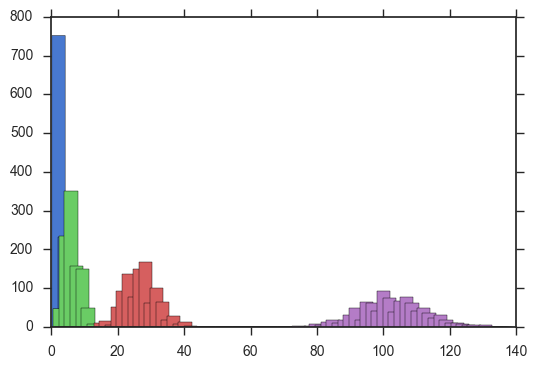

In [2]:
lambdas = [1, 5, 25, 100]
poisson_samples = [numpy.random.poisson(l, 1000) for l in lambdas]
_ = pyplot.hist(poisson_samples, bins=80, width=4)

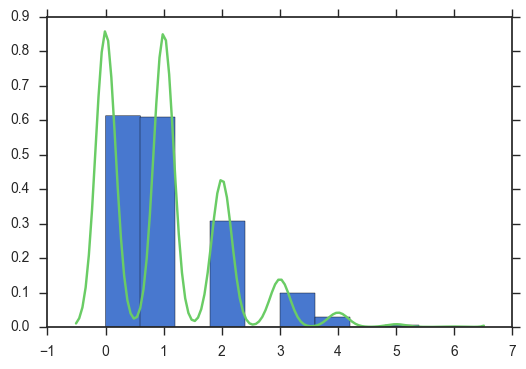

In [3]:
poisson_samples = numpy.random.poisson(1, 10000)
pyplot.hist(poisson_samples, normed=True)
seaborn.kdeplot(poisson_samples)

Let's look at the difference between modeling the customer arrivals as a Poisson distribution versus a normal distribution.

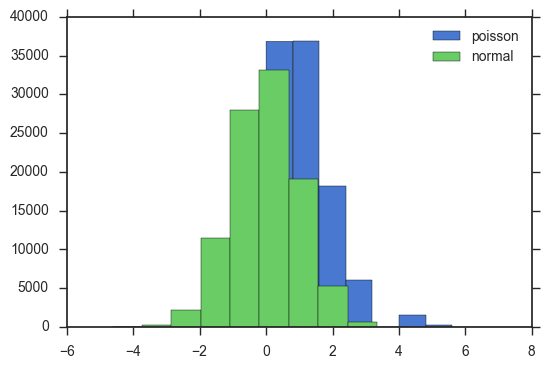

In [4]:
mu = 0
sigma = 1

num_samples = 100000
norm_samples = numpy.random.normal(loc=mu, scale=sigma, size=num_samples)
poisson_samples = numpy.random.poisson(lam=sigma, size=num_samples)
pyplot.hist(poisson_samples, label='poisson')
pyplot.hist(norm_samples, label='normal')
_ = pyplot.legend()

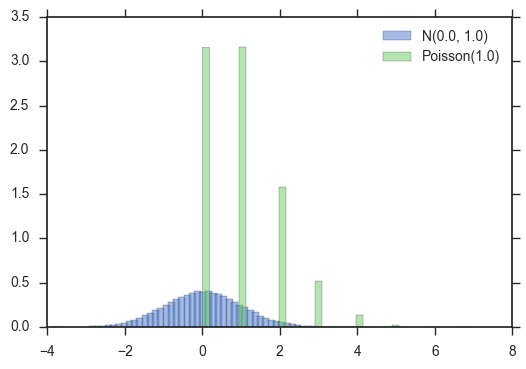

In [5]:
def plot_dists(num_samples, mu=0, sigma=1):

  norm_samples = numpy.random.normal(
      loc=mu, scale=sigma, size=num_samples)
  poisson_samples = numpy.random.poisson(
      lam=sigma**2, size=num_samples)  
  
  dists = pandas.DataFrame({
      'norm': norm_samples,
      'poisson': poisson_samples,
  })

  min_x = dists.min().min()
  max_x = dists.max().max()
  bw = (max_x - min_x) / 60
  pyplot.hist(dists.norm, width=bw, bins=60,
              label='N(%.1f, %.1f)' % (mu, sigma), alpha=.5, normed=True)
  pyplot.hist(dists.poisson, width=bw, bins=60,
              label='Poisson(%.1f)' % sigma, alpha=.5, normed=True)
  pyplot.legend()
  
plot_dists(100000)

**Your turn:** In the cells below, compute the following:

- The Normal and Poisson distributions for 1000, 10000 and 100000 realizations. 
- The Normal and Poisson distributions for an expected value of 200, 100, and 50 with 100000 realizations.

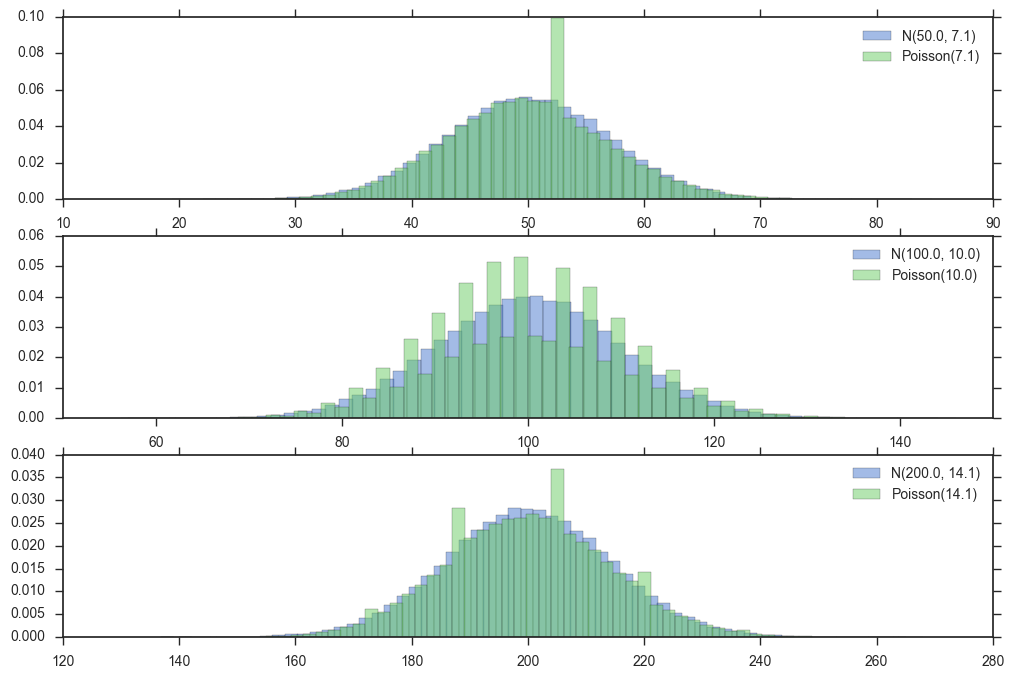

In [6]:
pyplot.figure(figsize=(12, 8))
for i, mu in enumerate([50, 100, 200]):
  pyplot.subplot(3, 1, i+1)  
  plot_dists(100000, mu=mu, sigma=numpy.sqrt(mu))

## Simulate Demand

In order to develop an overall profitability model the demand must be simulated. To simulate demand you must first simulate the number of arrivals and then the demand for each type of bread given the arrivals. 

The demand for bread on a given day is sumulated with the code in the cell below. Given the number of arrivals `n`, the `sim.bread` function computes the numbers of each type of bread required. The last line of code in the the cell tests the function for 100 realizations. Run this code and examine the result.

In [7]:
def sim_bread(num_samples):
  bread_probas = [
      .50,  # white
      .25,  # wheat
      .25,  # multigrain
  ]
  
  return list(zip(
      ['white', 'wheat', 'multigrain'], 
      numpy.random.multinomial(num_samples, bread_probas)))
  
sim_bread(100)

[('white', 57), ('wheat', 18), ('multigrain', 25)]

Examine the table of demand by type of bread. Notice that the proportions of white, wheat and muligrain are approximately 2, 1, 1, respectively. You can now compute the bread demand for one realization of arrivals.  

Next, you must simulate realizaitons of arrivals of people at the sandwich shop. Often arrival rates, k, per time interval are modeled as a Poisson process with rate or intesity $\lambda$, which can be written:

$$P(k\ arrivals\ | \lambda\ average\ arrival\ rate) = \frac{\lambda^k\ e^{-\lambda}}{k!}$$

The demand for bread is clealy dependent on the number of arrivals, as well as the probability that customers choose each type of bread. In other words, what you need to compute is the conditional distribuion of bread demand given arrivals, or $P(bread\ |\ arrivals)$.

The code in the cell below performs the following operations:

- The distribution of the arrivals in computed by realizations of a Poisson distribution.
- A matrix is created to hold  the demand for each bread type for each realization of the arrivals.
- Loop over the realizations of the arrivals, compute the demand for each bread type, and save the results in a row of the matrix.

Execute this code and  examine the results.

In [8]:
def sim_demand(lam, num_samples):
  # Compute realizations of arrivals
  arrivals = numpy.random.poisson(lam=lam, size=num_samples)
  # Initalize a matrix
  demand_matrix = numpy.zeros((num_samples, 3), dtype=int)
  
  for i, a in enumerate(arrivals):
    breads, counts = zip(*sim_bread(a))
    # Add one realization to matrix
    demand_matrix[i] = counts
  demand = pandas.DataFrame(demand_matrix, columns=breads)
  
  return demand

sim_demand(100, 10)

,white,wheat,multigrain
0,61,24,25
1,40,25,23
2,55,21,22
3,59,23,24
4,51,19,21
5,35,28,24
6,54,23,27
7,60,18,21
8,39,24,26
9,53,34,24


**Your Turn:** Plot the distribution of at least one bread type based on 10000 realizations.

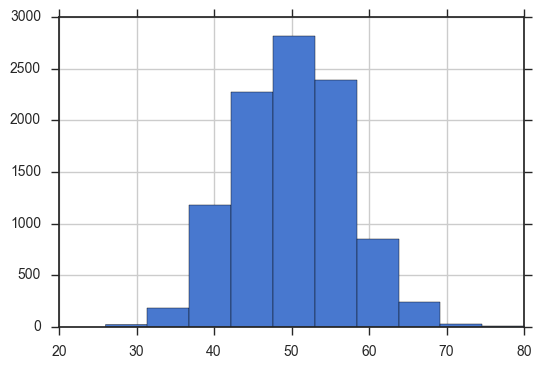

In [9]:
sim_demand(100, 10000).white.hist(label='white')

## Simulate Bread Baked

The number of each type of bread baked in the sandwich shop is deterministic. Presumably the shop manager has a plan for the day, and the bread is baked in advance of the customer arrivals. The code in the cell below computes a data frame containing the number of loaves of each type of bead baked. Run this code to test the function.

In [10]:
def baked_bread(n):
  baked = (['white'] * (n//2)) + (['wheat'] * (n//4)) + (['multigrain'] * (n//4))
  bread_available = dict(pandas.Series(baked).value_counts())
  return pandas.DataFrame({k:[v] for k,v in bread_available.items()})

baked_bread(100)

,multigrain,wheat,white
0,25,25,50


## Simulate and plot profit

You now have almost all the pieces in place to create the complete simulation of the distribution of profitability of the sandwich shop. The only missing piece is to compute the total profit based on the number of sandwiches sold and the cost of the bread baked. 

The calculation of the profit is done by bread type. If the demand for a bread type is less that the available bread, the cost of the bread is subtracted by the profit at that demand. If the demand is greater than the available bread, the profit is limited by the amount of bread available. 

The code in cell below performs the following operations:

- Compute the amount of bread baked.
- Compute the realizations of demand by bread type.
- For each realization of each bread type, compute the profit based on the available bread.

Run this code and examine the results.

In [11]:
baked = 100
n = 10
lam = 100
earned = 1.
cost = .25

def baked_bread_samples(n_samples, n_bread):
    """Sample breads baked each day."""
    return pandas.concat([
            baked_bread(n_bread) for i in range(n_samples)]
                        ).reset_index(drop=True)

bread_samples = baked_bread_samples(n, baked)
demand_samples = sim_demand(lam, n)

demand_samples

,white,wheat,multigrain
0,50,24,24
1,44,26,18
2,42,29,19
3,47,15,24
4,59,30,29
5,47,30,21
6,44,17,26
7,63,34,23
8,52,15,25
9,53,17,27


In [12]:
def sim_profit(n_baked, n, lam, earned, cost):

    # Draw samples for bread baking supply each day.
    bread_samples = baked_bread_samples(n, n_baked)
    # Draw samples for demand each day.
    demand_samples = sim_demand(lam, n)    
    # Combine the supply and demand into a single dataframe.
    supply_demand = pandas.merge(
        bread_samples, 
        demand_samples, 
        left_index=True, 
        right_index=True,
        how='inner',
        suffixes=('_supply', '_demand'))
    
    # Define how we'll get profit for a single day
    def get_profit(day):
        profit = 0
        breads = 'multigrain', 'wheat', 'white'
        for b in breads:
            supply = day['%s_supply' % b]
            demand = day['%s_demand' % b]
            # Determine how much of our bread supply was sold vs wasted.
            leftover = supply - demand
            if leftover >= 0: # If yes, compute profit
                profit += earned * demand - cost * supply
            else: # If no, limited by available bread
                profit += (earned - cost) * supply
        return profit
    
    #  Compute the profit for each data and store result in a new column.
    supply_demand['profit'] = supply_demand.apply(get_profit, axis=1)
    
    return supply_demand
    
profits = sim_profit(100, 10, 100, 1.00, .25)
profits

,multigrain_supply,wheat_supply,white_supply,white_demand,wheat_demand,multigrain_demand,profit
0,25,25,50,43,23,27,66.0
1,25,25,50,52,20,21,66.0
2,25,25,50,47,21,29,68.0
3,25,25,50,53,29,22,72.0
4,25,25,50,43,18,27,61.0
5,25,25,50,38,26,21,59.0
6,25,25,50,49,19,21,64.0
7,25,25,50,52,30,27,75.0
8,25,25,50,53,22,24,71.0
9,25,25,50,43,22,25,65.0


For a large number of realizations, it is easier to study the resulting distribution using summary statistics and plots. Run the code in the cell below to simulate a large number of trials that we'll plot further below

In [13]:
profits = sim_profit(100, 10000, 100, 1.00, .25)

Let's compute the total demand across all bread types for each day as well

In [14]:
def total_demand(day):
    return sum(day[c] for c in day.keys() if 'demand' in c)

profits['total_demand'] = profits.apply(total_demand, axis=1)
profits.head()

,multigrain_supply,wheat_supply,white_supply,white_demand,wheat_demand,multigrain_demand,profit,total_demand
0,25,25,50,42,23,20,60.0,85.0
1,25,25,50,57,24,28,74.0,109.0
2,25,25,50,51,28,22,72.0,101.0
3,25,25,50,52,25,20,70.0,97.0
4,25,25,50,57,23,23,71.0,103.0


We can now see the distribution of demand over the days of our simulation

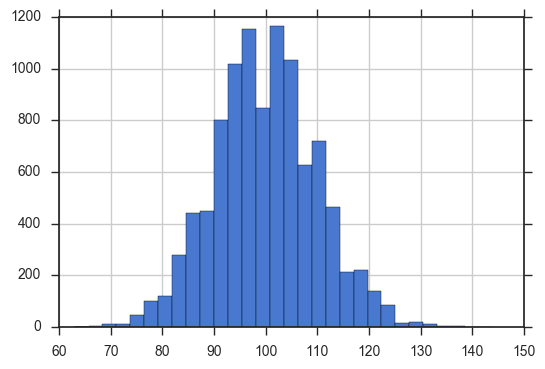

In [15]:
profits.total_demand.hist(bins=30)

and also the distribution of daily profits during the course of the simulation

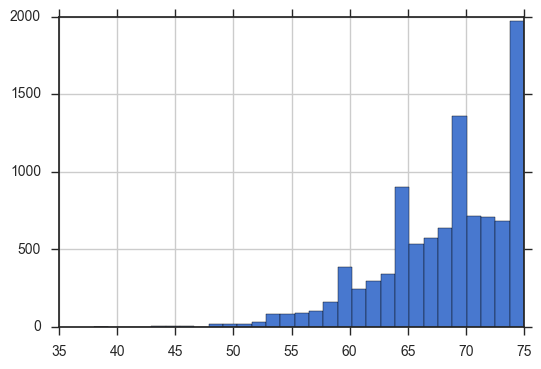

In [16]:
profits.profit.hist(bins=30)

Let's wrap up our plotting code in a function so that we can reuse it for different scenarios we'd like to simulate.

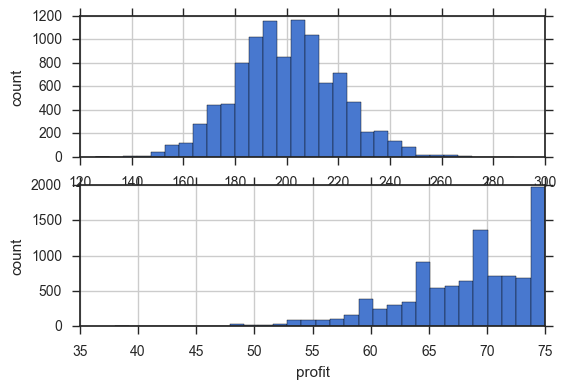

In [17]:
def plot_scenario(profits):
    profits['total_demand'] = profits.apply(total_demand, axis=1)
    
    pyplot.subplot(2, 1, 1)
    profits.total_demand.hist(bins=30)
    pyplot.xlabel('total demand')
    pyplot.ylabel('count')

    pyplot.subplot(2, 1, 2)
    profits.profit.hist(bins=30)
    pyplot.xlabel('profit')
    pyplot.ylabel('count')

plot_scenario(profits)

**Your turn:** In the cell below, create and execute the code to examine the chart of profit for  the cases where 120, 140, and 160 loaves of bread have been baked. 

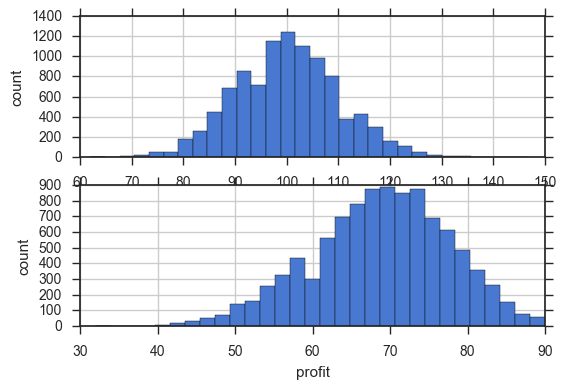

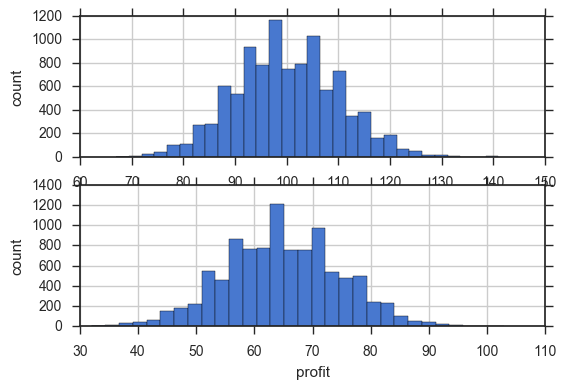

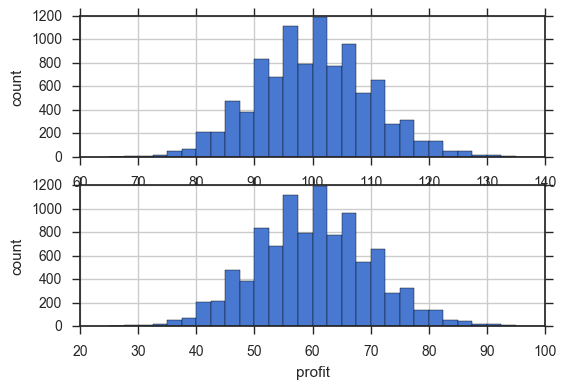

In [18]:
for n_bread in (120, 140, 160):
    plot_scenario(
        sim_profit(n_bread, 10000, 100, 1.00, .25))
    pyplot.show()

## Profit vs. Bread Baked

Of several remaining quesitons, a manager of the sandwich shop might be most interested in the relationship between profitability and the number of loaves of bread baked. Understanding this relationship will help the manager optimize the profit of the shop. 

Since there is only one variable in this case, it is a simple matter to step over some likely values and find the one which optimizes the profit of the shop. The code in the cell does just this and plots a graph of the result. Run the code and examine the result. 

In [19]:
bread_counts = (60, 80, 100, 120, 140, 160)
mean_profits = [sim_profit(n_bread, 10000, 100, 1.00, .25).profit.mean()
    for n_bread in bread_counts]

scenarios = pandas.DataFrame({'baked': bread_counts, 'profits': mean_profits})
scenarios

,baked,profits
0,60,44.9459
1,80,58.9869
2,100,68.2714
3,120,68.8528
4,140,64.8902
5,160,60.0803


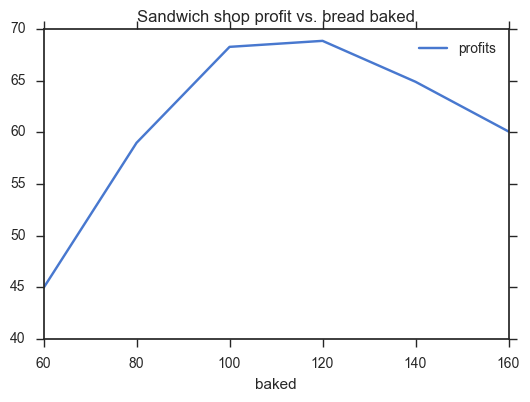

In [20]:
scenarios.plot(x='baked', y='profits')
pyplot.title('Sandwich shop profit vs. bread baked')

There is still the issue of how much the results of this simulation vary from run to run. With a bit more code, the results of a number of number of simulation runs, the mean value, and the standard deviation of the profit across simulation runs can be computed and displayed. 

Run this code and examine the printed and ploted results. 

In [21]:
def sim_profit_replicas(n_replicas, bread_counts, n_days, lam, earned, cost):
    all_scenarios = []
    for replica_i in range(n_replicas):
        mean_profits = [sim_profit(n_bread, n_days, lam, earned, cost).profit.mean()
            for n_bread in bread_counts]
        scenarios = pandas.DataFrame({'baked': bread_counts, 'profits': mean_profits})
        scenarios['replica_i'] = replica_i
        all_scenarios.append(scenarios)
        
    return pandas.concat(all_scenarios)

replicas = sim_profit_replicas(
    n_replicas=100, 
    bread_counts=(60, 80, 100, 120, 140, 160), 
    n_days=100, 
    lam=100, 
    earned=1.00, 
    cost=.25)

In [22]:
replicas.head()

,baked,profits,replica_i
0,60,44.98,0
1,80,59.13,0
2,100,68.10,0
3,120,71.09,0
4,140,64.68,0


We can easily compute the standard deviation of the mean daily profit across our simulation replicas like so

In [23]:
replicas.groupby('baked').profits.std()

baked
60     0.037430
80     0.200076
100    0.586611
120    0.799569
140    1.003243
160    1.030890
Name: profits, dtype: float64

And now we can plot each of the simulation replicas to get a sense of the profit variance for each amount of bread we might bake daily.

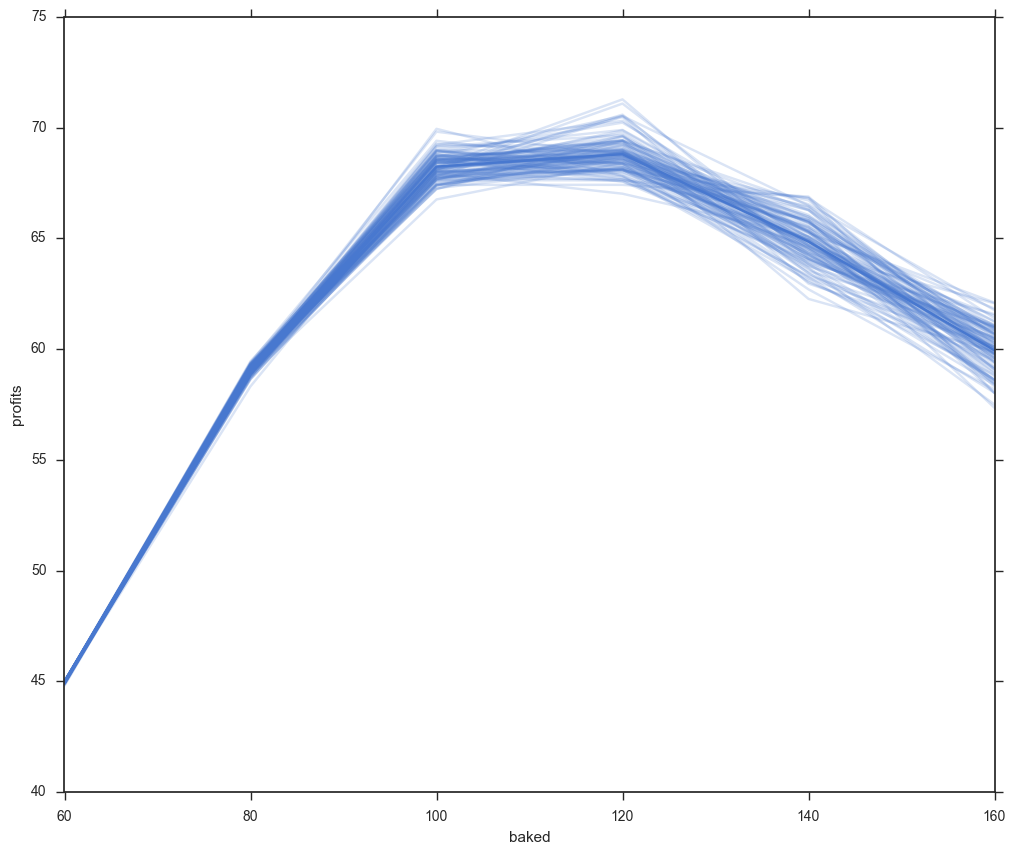

In [24]:
pyplot.figure(figsize=(12, 10))
seaborn.tsplot(
    replicas, time='baked', unit='replica_i', value='profits',
    err_style='unit_traces')

For most part the difference in profits between 100 and 120 loaves of bread prepared is minimal. This is particularly the case if you look at the standard deviation of these means. 

**Your turn:** In the cell below, create and exectue the code to simulate the profitabity of the sandwich show vs. bread baked for the case the bread costs 0.1, using 100 runs. How is the behavior of the result different from before.